<a href="https://colab.research.google.com/github/rafal-bro/techlabs-instance-segmentation/blob/main/3_inference_mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Inference Mask R-CNN** 

## Introduction

In this notebook, the trained model is loaded and detection is performed on unseen image data. The results will be visualized and saved to file.

## Setting up the Environment

Install required packages and specify versions.

In [2]:
%tensorflow_version 1.x
!pip install --upgrade h5py==2.10.0

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 12.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [3]:
!nvidia-smi

Mon Jun 13 06:30:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import modules and mount drive.

In [4]:
import os
import sys
import pickle

import pandas as pd
import skimage.io
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Specify paths.

In [5]:
# specify root to kuzikus_group04 folder
PROJECT_ROOT = r'/content/drive/MyDrive/techlabs_instance_segmentation'

# specify folder holding inference dataset (pure images) - folder must be placed in 'data' folder of project
INFERENCE_FOLDER = 'kuzikus_coco_1024_inference'

# if True, detections will be saved - dependend on image number this might take some time
SAVE_DETECTIONS = True

# image size
IMG_SIZE = 1024

In [6]:
# specify path to Mask R-CNN folder
ROOT_DIR = os.path.join(PROJECT_ROOT, 'Mask_RCNN')

# specify path to folder containing helper functions
HELPER_DIR = os.path.join(PROJECT_ROOT, 'helper_functions')

# specify directory containing inference data - just images - without annotations
INFERENCE_DIR = os.path.join(PROJECT_ROOT, 'data', INFERENCE_FOLDER)

# directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [7]:
# import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# import helper functions
sys.path.append(HELPER_DIR)
sys.path.append(PROJECT_ROOT)
import postprocessing as pst
from m_rcnn import *

Using TensorFlow backend.


## Perform Detection

Configure model. In the first step use the same configuration as used for training.

In [8]:
class KuzikusConfig(Config):
    """
    Configuration used for training on the kuzikus dataset.
    Derives from the base Config class and overrides specific values.
    """
    NAME = 'kuzikus'

    # batch size is  (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # number of classes (including background)
    # (background) + (tree, bush, animal, road, aardvark_hole, dead_tree)
    NUM_CLASSES = 1 + 6

    # image dimensions
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 20
    EPOCHS = 50
    
    # use resnet50 for fast results
    # try resnet101 for a much deeper network
    BACKBONE = 'resnet101'

Overwrite some values for inference.

In [9]:
class InferenceConfig(KuzikusConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # suppress overlapping masks in inference model
    DETECTION_MIN_CONFIDENCE = 0.75
    DETECTION_NMS_THRESHOLD = 0.2

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.2
EPOCHS                         50
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE   

Load inference model.

In [10]:
# the latest trained model will be loaded
model = load_inference_model(inference_config, MODEL_DIR)

Loading weights from  /content/drive/MyDrive/techlabs_instance_segmentation/Mask_RCNN/logs/kuzikus20220611T0129/mask_rcnn_kuzikus_0100.h5
Re-starting from epoch 100


In [11]:
# get class names in correct order
DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'kuzikus_coco_1024')
dataset_train = load_image_dataset(os.path.join(DATA_DIR, 'train.json'), DATA_DIR, 'train')
CLASS_NAMES = dataset_train.class_names

Annotation json path:  /content/drive/MyDrive/techlabs_instance_segmentation/data/kuzikus_coco_1024/train.json


Load image data and perform inference on one random image.

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -117.70000  max:  131.30000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


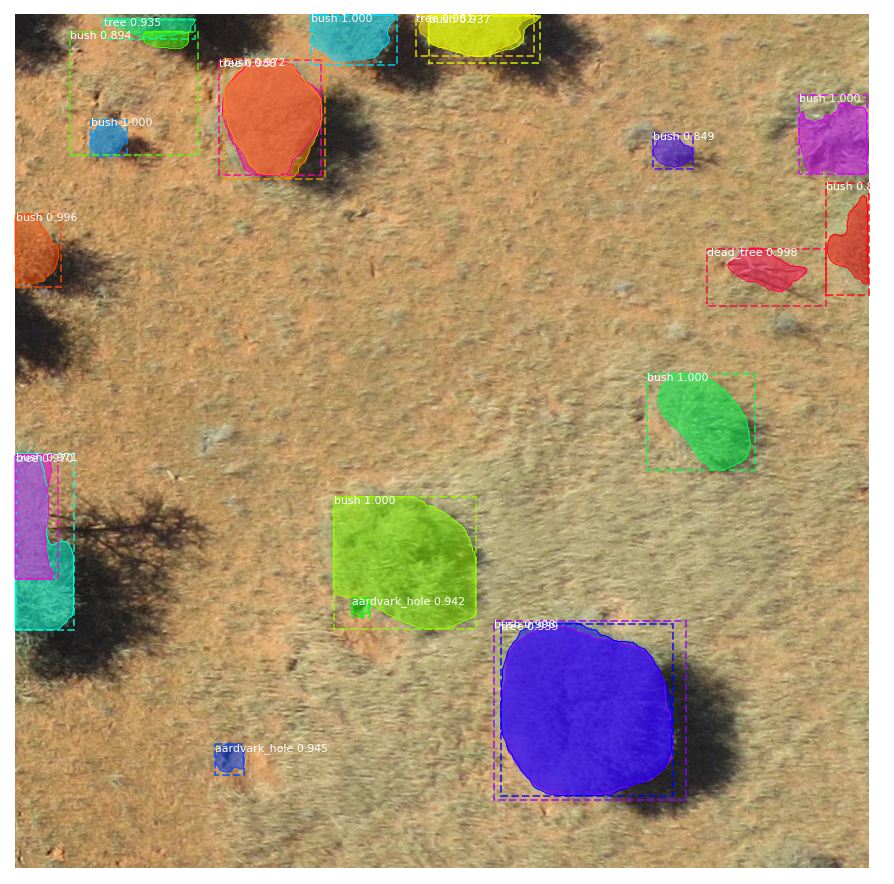

In [13]:
# Load a random image from the images folder
file_names = next(os.walk(INFERENCE_DIR))[2]
image = skimage.io.imread(os.path.join(INFERENCE_DIR, random.choice(file_names)))

# run detection
results = model.detect([image], verbose=1)

# visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            CLASS_NAMES, r['scores'])

Perform inference on remaining image data and save detection results as csv. In the next chapter these results will be loaded and analysed.

In [14]:
if SAVE_DETECTIONS:
  try:
    df_detection = pd.read_csv(os.path.join(INFERENCE_DIR, 'detections.csv'))
    print('Detection file already exists. Loading...')
  except:
    print('Processing images...')
    detection_dict = pst.get_detection_dict(model, IMG_SIZE, INFERENCE_DIR)

    df_detection = pd.DataFrame(detection_dict)
    df_detection.to_csv(os.path.join(INFERENCE_DIR, 'detections.csv'), index=False)

Detection file already exists. Loading...


The detection file contains information about animals and vegetation. It can be used for data analysis.

In [15]:
if SAVE_DETECTIONS:
  df_detection.head()

## Visualize

In [16]:
def show_instances(model, image_name, inference_path, class_names):
  image = skimage.io.imread(os.path.join(inference_path, image_name))
  # run detection
  results = model.detect([image], verbose=1)

  # visualize results
  r = results[0]
  display_instance_and_img(image, r['rois'], r['masks'], r['class_ids'], 
                              class_names, r['scores'], figsize=(20,15))

Filter detections and for example get all images with detected animals.

In [17]:
if SAVE_DETECTIONS:
  df_animals = df_detection[df_detection['cnt_animal']>0]

Show some images containing animals.

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


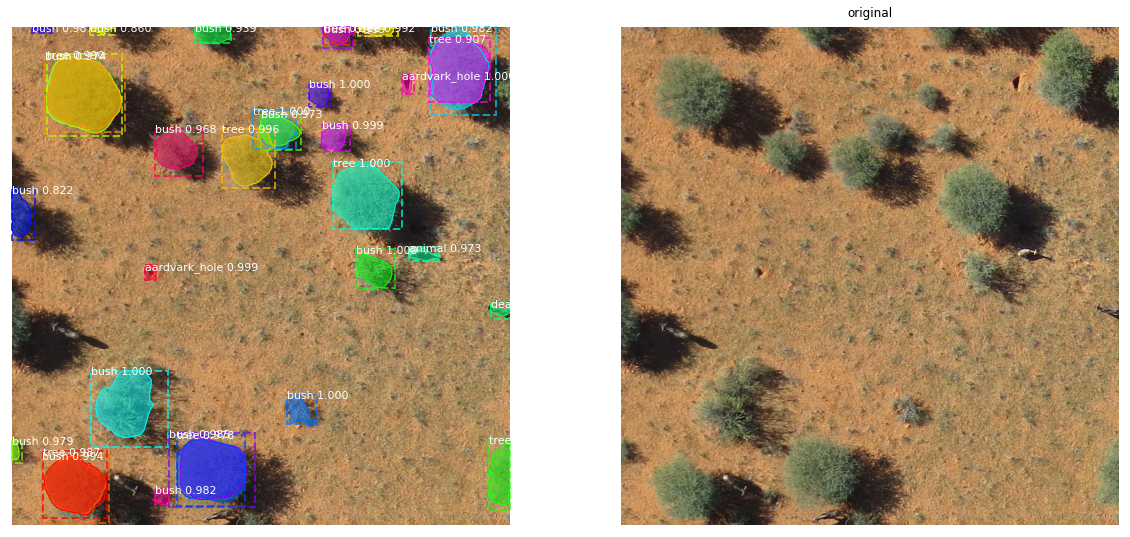

In [18]:
if SAVE_DETECTIONS:
  show_instances(model, df_animals['image'].iloc[3], INFERENCE_DIR, CLASS_NAMES)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -116.80000  max:  131.30000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


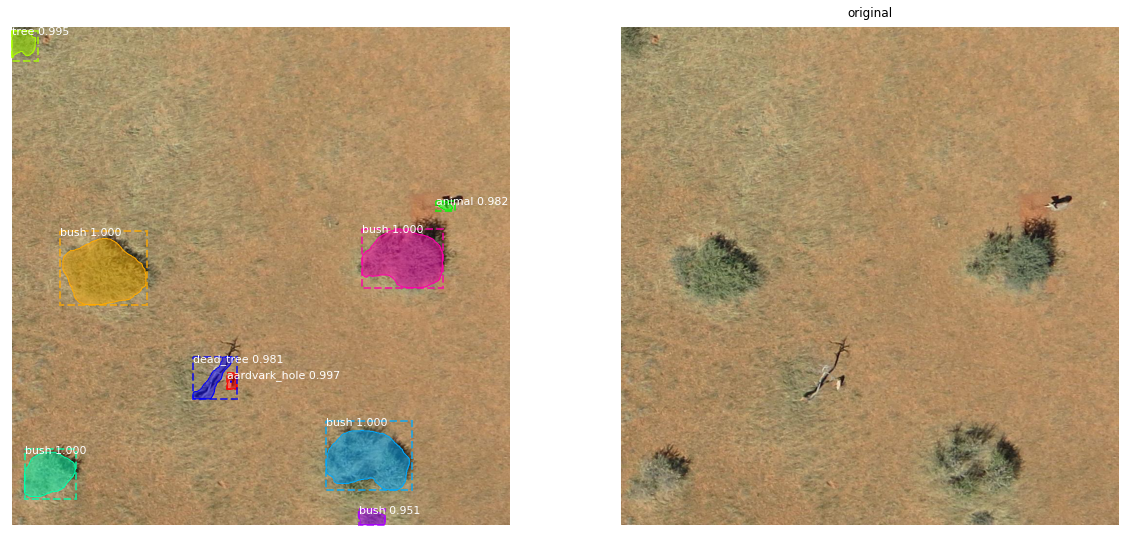

In [22]:
if SAVE_DETECTIONS:
  show_instances(model, df_animals['image'].iloc[9], INFERENCE_DIR, CLASS_NAMES)

In [20]:
df_detection.head()

image  cnt_tree  cnt_bush  \
0  799c9926a6f74683a57b6b34770a64fb_1024_1024_204...         1        12   
1  799c9926a6f74683a57b6b34770a64fb_0_1024_1024_2...         0         5   
2  799c9926a6f74683a57b6b34770a64fb_2976_1024_400...        11        16   
3  799c9926a6f74683a57b6b34770a64fb_2048_1024_307...         2        11   
4  799c9926a6f74683a57b6b34770a64fb_1024_1976_204...         2         3   

   cnt_vegetation  cnt_animal  cnt_deadtree  cnt_aardvarkhole  area_tree  \
0              13           0             0                 3       9514   
1               5           0             1                 1          0   
2              27           0             0                 2     155317   
3              13           0             0                 1      19135   
4               5           0             0                 0      35008   

   area_bush  area_vegetation  percentage_vegetation  area_road  
0      93407           102921                    9.8          0  
1      53993            53993                    5.1          0  
2     153728           309045                   29.5          0  
3      73234            92369                    8.8          0  
4      37363            72371                    6.9          0

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


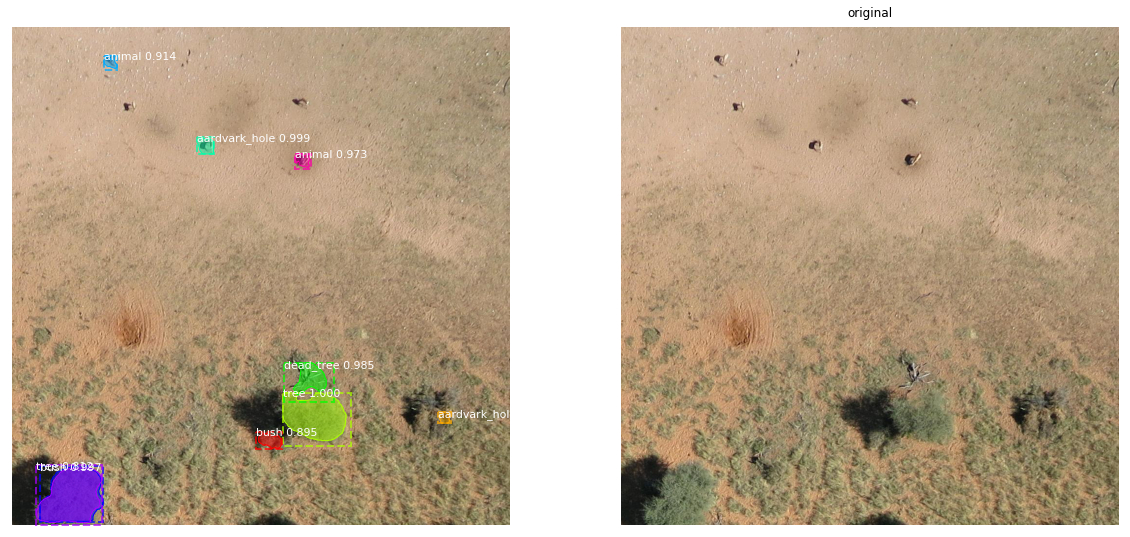

In [23]:
if SAVE_DETECTIONS:
  show_instances(model, df_animals['image'].iloc[12], INFERENCE_DIR, CLASS_NAMES)